# Burgers Equation UPINN experiment Notebook

In [3]:
# Relevant imports
import torch
import sys
import matplotlib.pyplot as plt
import numpy as np
from kan import KAN

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../../utils')
from upinn import UPINN
from architectures import FNN, ResNet
from utils import RAD_sampler, sample_collocation_points
from BurgerData import BurgerData

Consider Burgers equation:

\begin{align}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
\end{align}

where $u(x,t)$ is the velocity field, $\nu$ is the viscosity coefficient, $x \in [-1,1]$ and $t \in [0,1]$. The initial condition is $u(x,0) = -\sin(\pi x)$ and the boundary conditions are $u(-1,t) = u(1,t) = 0$.

### Load data

In [4]:
# Load data
noise_level = 0.1
time_slices = [25, 50, 99]
data = BurgerData(time_slices=time_slices, noise_level=noise_level)
Xd, Ud = data.data_points

### Setup training data

In [5]:
# Initial condition
N_ic = N_bc = 100
x0 = torch.linspace(-1, 1, N_ic)
X0, U0 = torch.stack((torch.zeros_like(x0), x0), dim=-1), -torch.sin(torch.pi * x0).reshape(-1, 1)

# Boundary condition
t_bc = torch.linspace(0, 1, N_bc)
XL, XR = torch.stack((t_bc, -torch.ones_like(t_bc)), dim=-1), torch.stack((t_bc, torch.ones_like(t_bc)), dim=-1)
U_bc = torch.zeros_like(t_bc).reshape(-1, 1)

# All boundary conditions
Xbc = torch.cat((X0, XL, XR), dim=0)
Ubc = torch.cat((U0, U_bc, U_bc), dim=0)

In [6]:
# Collocation points
N_coll = 10000
Xc = sample_collocation_points(N_coll, 2, lb=[0, -1], ub=[1, 1], method='sobol')

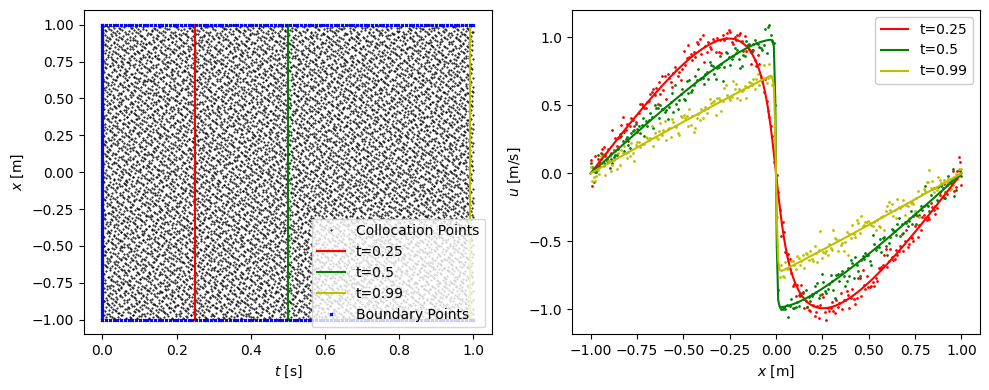

In [7]:
Ud_noiseless = data.data_points_full[1]

colors = ['r', 'g', 'y']

ax, fig = plt.subplots(1, 2, figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(Xc[:, 0], Xc[:, 1], 'k.', label='Collocation Points', markersize=1)

for i, t in enumerate(time_slices):
    plt.plot([t/100]*256, data.x, color=colors[i], label=f"t={data.t[t][0]}") 

plt.plot(Xbc[:, 0], Xbc[:, 1], 'bx', label='Boundary Points', markersize=2)
plt.xlabel(r'$t$ [s]'); plt.ylabel(r'$x$ [m]'); plt.legend()

plt.subplot(1, 2, 2)
colors = ['r', 'g', 'y', 'y']
for i, t in enumerate(time_slices):
    plt.scatter(data.x, Ud.reshape(-1, len(time_slices))[:, i], color=colors[i], s=1)
for i, t in enumerate(time_slices):
    plt.plot(data.x, Ud_noiseless.reshape(data.original_shape)[:, t], color=colors[i], label=f"t={data.t[t][0]}")
plt.xlabel(r'$x$ [m]'); plt.ylabel(r'$u$ [m/s]')
plt.legend().get_frame().set_alpha(1)

plt.tight_layout()
plt.savefig('gfx/burger_data.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Known system $N_K$

In [125]:
class SparseBurger(torch.nn.Module):
    def __init__(self, nu):
        super(SparseBurger, self).__init__()
        self.nu = nu
    
    def forward(self, X, u):

        d2udxt = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True)[0]
        u_t = d2udxt[:,0:1]
        u_x = d2udxt[:,1:2]

        u_xx = torch.autograd.grad(d2udxt, X, torch.ones_like(d2udxt), create_graph=True)[0][:,1:2]

        return u_t - self.nu*u_xx
    
nu = 0.01/torch.pi
N = SparseBurger(nu)

### Problem specific UPINN functions

In [ ]:
class UPINN(UPINN):
    
    def score(self):
        return torch.nn.MSELoss()(self.predict(data.data_points_full[0]), data.data_points_full[1]).item() # MSE
        # return max(abs(self.predict(data.data_points_full[0]) - data.data_points_full[1])).item() # MAE
    
    def score_residual(self):
        z = torch.clone(data.data_points_full[0]).requires_grad_(True)
        u = self.u(z)
        u_x = torch.autograd.grad(u, z, torch.ones_like(u), create_graph=True)[0][:, 1:2]

        usol = data.usol
        xsol = data.xsol
        dudx = np.gradient(usol, xsol.flatten(), axis=0)
        # known_res = dudx*usol
        res_exp = u_x*u

        res_pred = self.F(self.F_input(z, u))

        
        temp = torch.cat((res_exp, res_pred), dim=1).T
        print(temp.shape)
        
        return torch.corrcoef(temp)[0, 1].item()
        

        # return torch.nn.MSELoss()(self.F(self.F_input(z, u)), u_x*u).item() # MSE
        # return max(abs((self.F(self.F_input(z, u)) - u_x*u))).item() # MAE

    # Inductive bias on F
    # def F_input(self, X, U):
    #     dudxt = torch.autograd.grad(U, X, torch.ones_like(U), create_graph=True)[0]
    #     u_t = dudxt[:,0:1]
    #     u_x = dudxt[:,1:2]
    #     return torch.cat((U, u_t, u_x), dim=-1)
    
    
    # No inductive bias on F
    def F_input(self, X, U):
        return torch.cat((X, U), dim=-1)
    
    # Only U
    # def F_input(self, X, U):
    #     return U
    
    def refine_collocation_points(self):
        N = 50*N_coll
        D = N_coll
        k = 0.5
        c = 0.1

        Xc = sample_collocation_points(N, 2, lb=[0, -1], ub=[1, 1], method='sobol').requires_grad_(True)

        # Compute the residual
        u = self.u(Xc)
        residual = abs(self.N(Xc, u) + self.F(self.F_input(Xc, u)))

        # self.collocation_points = RAD_sampler(Xc, residual, D, k, c) # RAD
        self.collocation_points = torch.concatenate((self.collocation_points, RAD_sampler(Xc, residual, D//10, k, c))) # RAR-D

    # def get_loss(self):
    #     bc_loss = self.bc_loss()
    #     data_loss = self.data_loss()
    #     pde_loss = self.pde_loss()
    #     lambdas = [0.4, 0.2, 0.8]
    #     loss = lambdas[0]*bc_loss + lambdas[1]*data_loss + lambdas[2]*pde_loss
    #     return loss, bc_loss, data_loss, pde_loss

    def plot(self, save=None):
        device = self.device
        self.to('cpu')

        usol = data.usol
        tsol = data.tsol
        xsol = data.xsol

        # Get network prediction

        z_plot = data.data_points_full[0].clone().detach().requires_grad_(True)
        u_pred = self.u(z_plot)

        dudz_pred = torch.autograd.grad(u_pred, z_plot, torch.ones_like(u_pred), create_graph=True)[0]
        u_t_pred = dudz_pred[:, 0:1]
        u_x_pred = dudz_pred[:, 1:2]

        res_pred = self.F(self.F_input(z_plot, u_pred))

        # Get the known solution
        dudx = np.gradient(usol, xsol.flatten(), axis=0)

        with torch.no_grad():
            
            u_pred = u_pred.reshape(data.original_shape).detach().numpy()
            u_t_pred = u_t_pred.reshape(data.original_shape).detach().numpy()
            u_x_pred = u_x_pred.reshape(data.original_shape).detach().numpy()
            res_pred = res_pred.reshape(data.original_shape).detach().numpy()

            plt.figure(figsize=(10, 3))

            # Slices of the predicted solution and the known solution
            plt.subplot(1, 2, 1)
            colors = ['b', 'g', 'r', 'c', 'm']  # Define a list of colors for the lines

            plt.plot(xsol, u_pred[:, 0], label='t=0', color=colors[0])
            plt.plot(xsol, u_pred[:, 25], label='t=0.25', color=colors[1])
            plt.plot(xsol, u_pred[:, 50], label='t=0.5', color=colors[2])
            plt.plot(xsol, u_pred[:, 75], label='t=0.75', color=colors[3])
            plt.plot(xsol, u_pred[:, 99], label='t=1', color=colors[4])

            plt.plot(xsol, usol[:, 0], '--', color=colors[0])
            plt.plot(xsol, usol[:, 25], '--', color=colors[1])
            plt.plot(xsol, usol[:, 50], '--', color=colors[2])
            plt.plot(xsol, usol[:, 75], '--', color=colors[3])
            plt.plot(xsol, usol[:, 99], '--', color=colors[4])

            plt.xlabel('x'); plt.ylabel('u')
            plt.legend()
            plt.title('Predicted Solution vs. Known Solution')


            # Slices of the predicted residuals and known residuals
            plt.subplot(1, 2, 2)

            plt.plot(xsol[45:55], res_pred[45:55, 0], label='t=0', color=colors[0])
            plt.plot(xsol[45:55], res_pred[45:55, 25], label='t=0.25', color=colors[1])
            plt.plot(xsol[45:55], res_pred[45:55, 50], label='t=0.5', color=colors[2])
            plt.plot(xsol[45:55], res_pred[45:55, 75], label='t=0.75', color=colors[3])
            plt.plot(xsol[45:55], res_pred[45:55, 99], label='t=1', color=colors[4])

            plt.plot(xsol[11:14], dudx[11:14, 0]*usol[11:14, 0], '--', color=colors[0])
            plt.plot(xsol[11:14], dudx[11:14, 25]*usol[11:14, 25], '--', color=colors[1])
            plt.plot(xsol[11:14], dudx[11:14, 50]*usol[11:14, 50], '--', color=colors[2])
            plt.plot(xsol[11:14], dudx[11:14, 75]*usol[11:14, 75], '--', color=colors[3])
            plt.plot(xsol[11:14], dudx[11:14, 99]*usol[11:14, 99], '--', color=colors[4])

            plt.xlabel('x'); plt.ylabel('Residual')
            plt.legend()
            plt.title('Predicted Residual vs. Known Residual')

            plt.tight_layout()
            plt.show()


            # Find the global vmin and vmax (same for all subplots)
            known_res = dudx*usol
            exp_res = u_x_pred*u_pred
            res_err = abs(res_pred - (exp_res))

            plt.figure(figsize=(8, 8))

            vmin = min(usol.min(), u_pred.min())
            vmax = max(usol.max(), u_pred.max())
            v = max(abs(vmin), abs(vmax))

            # Known solution
            plt.subplot(3, 2, 1)
            plt.imshow(usol, extent=(0, 1, -1, 1), origin='lower', aspect='auto', vmin=-1.25, vmax=1.25)
            plt.xlabel('t'); plt.ylabel('x')
            plt.title('Known Solution')
            plt.colorbar()

            # Predicted solution
            plt.subplot(3, 2, 3)
            plt.imshow(u_pred, extent=(0, 1, -1, 1), origin='lower', aspect='auto', vmin=-1.25, vmax=1.25)

            # Plot lines of the slices
            for t in time_slices:
                t_ = t/100
                plt.plot([t_, t_], [-1, 1], 'w-')

            plt.xlabel('t'); plt.ylabel('x')
            plt.title('Predicted Solution')
            plt.colorbar()

            vmin = min(known_res.min(), exp_res.min(), res_err.min(), res_pred.min())
            vmax = max(known_res.max(), exp_res.max(), res_err.max(), res_pred.max())
            v = max(abs(vmin), abs(vmax))

            # Known residual
            plt.subplot(3, 2, 2)
            plt.imshow(known_res, extent=(0, 1, -1, 1), origin='lower', aspect='auto', vmin=-v, vmax=v)
            plt.xlabel('t'); plt.ylabel('x')
            plt.title('Known Residual')
            plt.colorbar()

            # Predicted residual
            plt.subplot(3, 2, 4)
            plt.imshow(res_pred, extent=(0, 1, -1, 1), origin='lower', aspect='auto', vmin=-v, vmax=v)
            plt.xlabel('t'); plt.ylabel('x')
            plt.title('Predicted Residual')
            plt.colorbar()

            # Solution error
            plt.subplot(3, 2, 5)
            plt.imshow(abs(u_pred - usol), extent=(0, 1, -1, 1), origin='lower', aspect='auto')
            plt.xlabel('t'); plt.ylabel('x')
            plt.title('Solution Error')
            plt.colorbar()

            # Residual error
            plt.subplot(3, 2, 6)
            plt.imshow(abs(known_res - res_pred), extent=(0, 1, -1, 1), origin='lower', aspect='auto')
            plt.xlabel('t'); plt.ylabel('x')
            plt.title('Residual Error')
            plt.colorbar()

            plt.tight_layout()

            if save is not None:
                plt.savefig(save, dpi=600)
            plt.show()
        
        self.to(device)

### FNN

In [127]:
hidden = [20] * 8

u = FNN(
    dims=[2, *hidden, 1],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)

F = FNN(
    dims=[3, *hidden, 1],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)

### Ansatz

In [128]:
# class FNN_ansatz(FNN):
#     def __init__(self, **kwargs):
#         super(FNN_ansatz, self).__init__(**kwargs)
    
#     def forward(self, X):
#         return -torch.sin(torch.pi*X[:, 1:2]) + super(FNN_ansatz, self).forward(X)*(1 - X[:, 1:2])*(1 + X[:, 1:2])*torch.tanh(X[:, 0:1])
    
# u = FNN_ansatz(
#     dims=[2, *hidden, 1],
#     hidden_act=torch.nn.Tanh(),
#     output_act=torch.nn.Identity(),
# )

### ResNet

In [129]:
# u = ResNet(input_dim=2, hidden_dim=20, output_dim=1, num_blocks=4, block_size=2, activation=torch.nn.Tanh())
# F = ResNet(input_dim=3, hidden_dim=20, output_dim=1, num_blocks=4, block_size=2, activation=torch.nn.Tanh())

### KAN

In [130]:
# u = KAN([2, 4, 4, 1])
# F = KAN([3, 3, 1])

### UPINN

In [131]:
upinn = UPINN(u, N, F, boundary_points=(Xbc, Ubc), data_points=(Xd, Ud), collocation_points=Xc)

[Info]: Initializing UPINN model


### Load existing model

In [132]:
path = 'models'
name = 'tanh_softadapt_noisy_05_burger_upinn'
upinn.load(name=name, path=path)

### MSE

In [133]:
upinn.to('cpu')
print(f'Solution MSE:\t {upinn.score():.2e}')
print(f'Residual MSE:\t {upinn.score_residual():.2e}')

Solution MSE:	 1.55e-04
torch.Size([25600, 2])
Residual MSE:	 1.00e+00


In [105]:
path = 'models'
name = 'tanh_RAR_clean_sparse'
name = 'tanh_RAD_clean_sparse_burger'
name = 'tanh_sparse_burger_upinn'
upinn.load(name=name, path=path)
# upinn.plot('gfx/burger_RAR.png')
print(f'Solution MSE:\t {upinn.score():.2e}')
print(f'Residual MSE:\t {upinn.score_residual():.2e}')

Solution MSE:	 7.10e-03


TypeError: corrcoef(): argument 'input' (position 1) must be Tensor, not list

### Save model

In [ ]:
path = 'models'
name = 'test'
upinn.save(name=name, path=path)

[Info]: test already exists in save directory. Enumerating model as 6. To overwrite, set overwrite=True.
[Info]: Successfully saved total model with name test6 at models
